In [1]:
import proposal as pp
import numpy as np
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions_multi import get_angle_deviation
import os

In [2]:
data_dir = 'data/attwood/'
os.system('mkdir -p {}'.format(data_dir))

plot_dir = 'plots/attwood/'
os.system('mkdir -p {}'.format(plot_dir))

0

In [3]:
momentum = 168.9 # MeV/c , 172
m = 105.7 # MeV
E = np.round(np.sqrt(momentum**2 + m**2))


E_i = E # momentum # 1e9 # 1 PeV 
E_f = 1e1 # 1e5 # 100 GeV
n_events = 100000 
    
deflection = [
    'bremstsaiapproximation', # 'bremsginneken', # 'bremstsaiapproximation', 
    'ioniznaive',
    'photoborogpetrukhin', # 'photoginneken', # 'photoborogpetrukhin',
    'epairginneken'] ### same as default
    
e_cut = np.inf # 1e10
v_cut = 1e-5
cont_rand = False
scattering_method = "moliere" # "highland"
# deflection_type = "m_scat+stochastic"
  
# table_path = "/Users/pascalgutjahr/.cache/PROPOSAL" # macbook pro
table_path = "/net/nfshome/home/pgutjahr/.cache/PROPOSAL" # vollmond
    
rnd_seed = 71530

interpol_nodes = 200

initial_direction = [0, 0, 1]

beta_brems = 1.0
beta_ioniz = 1.0
beta_epair = 1.0
beta_multiplescatter = 1.0
beta_photonuclear = 1.0

max_dist = 10.9 # in cm = 109 mm

In [ ]:
pp.InterpolationSettings.tables_path = table_path   # version 7
    
pp.InterpolationSettings.nodes_dndx_e = interpol_nodes
pp.InterpolationSettings.nodes_dndx_v = interpol_nodes

pp.RandomGenerator.get().set_seed(rnd_seed)
args = {
        "particle_def": pp.particle.MuMinusDef(),
        "target": pp.medium.Hydrogen(),
        "interpolate": True,
        "cuts": pp.EnergyCutSettings(e_cut, v_cut, cont_rand)
        }

cross = pp.crosssection.make_std_crosssection(**args)
multiple_scatter = pp.make_multiple_scattering(scattering_method, args["particle_def"], args["target"], cross, True)

stochastic_deflect = []
for d in deflection:
    stochastic_deflect.append(pp.make_stochastic_deflection(d, 
    args["particle_def"], args["target"]))


collection = pp.PropagationUtilityCollection()
collection.displacement = pp.make_displacement(cross, True)
collection.interaction = pp.make_interaction(cross, True)
collection.time = pp.make_time(cross, args["particle_def"], True)
collection.decay = pp.make_decay(cross, args["particle_def"], True)


# collection.scattering = pp.scattering.ScatteringMultiplier(multiple_scatter, beta_multiplescatter)
# '''
collection.scattering = pp.scattering.ScatteringMultiplier(
    multiple_scatter, 
    stochastic_deflect, 
    beta_multiplescatter, 
    [(pp.particle.Interaction_Type.brems, beta_brems), (pp.particle.Interaction_Type.ioniz, beta_ioniz), 
    (pp.particle.Interaction_Type.epair, beta_epair), (pp.particle.Interaction_Type.photonuclear, beta_photonuclear)])
# '''

utility = pp.PropagationUtility(collection = collection)
detector = pp.geometry.Sphere(pp.Cartesian3D(0,0,0), 1e20) # version 7
density_distr = pp.density_distribution.density_homogeneous(args["target"].mass_density)


prop = pp.Propagator(args["particle_def"], [(detector, utility, density_distr)])

init_state = pp.particle.ParticleState()
init_state.position = pp.Cartesian3D(0, 0, 0) # version 7
init_state.direction = pp.Cartesian3D(initial_direction[0], initial_direction[1], initial_direction[2]) # version 7

# Run simulation

In [ ]:
tracks = []
for i in tqdm(range(n_events)):
    init_state.energy = E_i # initial energy in MeV
    track = prop.propagate(init_state, max_distance = max_dist, min_energy = E_f) # max_dist=1e9
    tracks.append(track)

In [ ]:
tracks_109 = []
for track in tracks:
    if track.track_propagated_distances()[-1] == 10.9:
        tracks_109.append(track)

In [ ]:
tracks_109_zenith = []
tracks_109_azimuth = []
tracks_109_x = []
tracks_109_y = []
tracks_109_z = []
tracks_109_pos_x = []
tracks_109_pos_y = []
tracks_109_pos_z = []
for track in tqdm(tracks_109):
    tracks_109_zenith.append(track.track_directions()[-1].spherical_coordinates[2])
    tracks_109_azimuth.append(track.track_directions()[-1].spherical_coordinates[1])
    tracks_109_x.append(track.track_directions()[-1].x)
    tracks_109_y.append(track.track_directions()[-1].y)
    tracks_109_z.append(track.track_directions()[-1].z)
    tracks_109_pos_x.append(track.track_positions()[-1].x)
    tracks_109_pos_y.append(track.track_positions()[-1].y)
    tracks_109_pos_z.append(track.track_positions()[-1].z)

In [ ]:
bins = np.linspace(-np.pi, np.pi, 50)
plt.hist(tracks_109_azimuth, bins=bins, histtype='step', label='azimuth')
plt.hist(tracks_109_zenith, bins=bins, histtype='step', label='zenith')
plt.xlabel('angle in rad')
plt.yscale('log')
plt.legend()

In [ ]:
def projection(y, z):
    if not isinstance(y, np.ndarray):
        y = np.array(y)
    if not isinstance(z, np.ndarray):
        z = np.array(z)
    return np.tan(y / z)

In [ ]:
# reproduziere den plot von attwood -> irgendwie muss der winkel noch berücksichtigt werden, wie?
# lese schon mal die daten von attwood ein und erzeuge dann einen auf 100% normierten bar plot

In [ ]:
# read in unfoled data of Attwood, angle in rad and probability in percent
Attwood = pd.read_csv('data/attwood/Attwood_unfolded_data.csv', sep=';', decimal=',', names=['angle', 'probability']) 
print('total probability attwood: ', np.sum(Attwood.probability))
GEANT4 = pd.read_csv('data/attwood/Attwood_GEANT4.csv', sep=';', decimal=',', names=['angle', 'probability']) 

In [ ]:
plt.plot(Attwood.angle, Attwood.probability, '.', label='Attwood')

bins = np.linspace(-0.1, 0.1, 50)
plt.hist(projection(tracks_109_y, tracks_109_z), bins=bins, histtype='step', density=True, label='tan(y/z)')

plt.ylabel('normalized counts')
plt.xlabel('angle in rad')
plt.yscale('log')
plt.legend()

In [ ]:
bins = (np.linspace(-0.1, 0.1, 50), np.linspace(-0.1, 0.1, 50))
n = plt.hist2d(tracks_109_x, tracks_109_y, bins=bins, norm=mpl.colors.LogNorm(), cmap=mpl.cm.gray)
plt.colorbar()
np.max(n[0])

## save data

In [ ]:
# '''
df = pd.DataFrame()
df['tracks_109_x'] = tracks_109_x
df['tracks_109_y'] = tracks_109_y
df['tracks_109_z'] = tracks_109_z
df['tracks_109_pos_x'] = tracks_109_pos_x
df['tracks_109_pos_y'] = tracks_109_pos_y
df['tracks_109_pos_z'] = tracks_109_pos_z
df['tracks_109_zenith'] = tracks_109_zenith
df['tracks_109_azimuth'] = tracks_109_azimuth
key = 'E{}_{}_v_cut{}_G4defl'.format(int(E_i), scattering_method, v_cut)
df.to_hdf(data_dir + 'sim_data.hdf5', key=key)
print(key)
# '''

## read data

In [11]:
key_0 = 'E199_moliere_v_cut0.001'
df_0 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_0)
# df_0.to_hdf(data_dir + 'sim_data.hdf5', key=key_0)

key_1 = 'E168_moliere_v_cut0.001'
df_1 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_1)
# df_1.to_hdf(data_dir + 'sim_data.hdf5', key=key_1)

key_2 = 'E199_highland_v_cut0.001'
df_2 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_2)
# df_2.to_hdf(data_dir + 'sim_data.hdf5', key=key_2)

key_3 = 'E168_highland_v_cut0.001'
df_3 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_3)
# df_3.to_hdf(data_dir + 'sim_data.hdf5', key=key_3)

key_4 = 'E168_moliere_v_cut1e-05'
df_4 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_4)
# df_4.to_hdf(data_dir + 'sim_data.hdf5', key=key_4)

key_5 = 'E199_moliere_v_cut1e-05'
df_5 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_5)
# df_5.to_hdf(data_dir + 'sim_data.hdf5', key=key_5)

key_6 = 'E199_moliere_v_cut1e-05_G4defl'
df_6 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_6) # not relevant because there are only ionizations -> hence the
# deflection parametrization for brems and nuclint does not effect anything

key_7 = 'E199_only_moliere_v_cut1e-05'
df_7 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_7)

# Plot all 

In [ ]:
binning = [Attwood.angle[i] - abs(Attwood.angle[i+1] - Attwood.angle[i])/2 for i in range(len(Attwood)-1)]
binning.append(Attwood.angle.values[-1] - abs(Attwood.angle.values[-1] - Attwood.angle.values[-2])/2)
binning.append(Attwood.angle.values[-1] + abs(Attwood.angle.values[-1] - Attwood.angle.values[-2])/2)
binning

In [ ]:
# plot y direction


plt.plot(Attwood.angle, Attwood.probability, 'o', color='black', alpha=0.7, label='Attwood')
plt.plot(GEANT4.angle, GEANT4.probability, '^', color='black', alpha=0.7, label='GEANT4')

bins = binning # np.linspace(-0.11, 0.11, 50)
plt.hist(df_0.tracks_109_y, bins=bins, histtype='step', density=True, label=key_0)
plt.hist(df_1.tracks_109_y, bins=bins, histtype='step', density=True, label=key_1)
plt.hist(df_5.tracks_109_y, bins=bins, histtype='step', density=True, label=key_5)
plt.hist(df_4.tracks_109_y, bins=bins, histtype='step', density=True, label=key_4)
plt.hist(df_2.tracks_109_y, bins=bins, histtype='step', density=True, label=key_2)
plt.hist(df_3.tracks_109_y, bins=bins, histtype='step', density=True, label=key_3)
# plt.hist(df_6.tracks_109_y, bins=bins, histtype='step', density=True, label=key_6)



plt.ylabel('normalized counts')
plt.xlabel('y angle in rad')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(plot_dir + 'attwood_comparison_all.pdf', bbox_inches='tight')

In [ ]:
# plot y direction

plt.plot(Attwood.angle, Attwood.probability, 'o', color='black', alpha=0.7, label='Attwood')
plt.plot(GEANT4.angle, GEANT4.probability, '^', color='black', alpha=0.7, label='GEANT4')

binning = [Attwood.angle[i] - abs(Attwood.angle[i+1] - Attwood.angle[i])/2 for i in range(len(Attwood)-1)]
binning.append(Attwood.angle.values[-1] - abs(Attwood.angle.values[-1] - Attwood.angle.values[-2])/2)
binning.append(Attwood.angle.values[-1] + abs(Attwood.angle.values[-1] - Attwood.angle.values[-2])/2)

bins = binning # np.linspace(-0.11, 0.11, 50)
plt.hist(df_2.tracks_109_y, bins=bins, histtype='step', density=True, label=key_2)
plt.hist(df_3.tracks_109_y, bins=bins, histtype='step', density=True, label=key_3)



plt.ylabel('normalized counts')
plt.xlabel('y angle in rad')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.title('highland')
plt.savefig(plot_dir + 'attwood_comparison_highland.pdf', bbox_inches='tight')

In [ ]:
# plot y direction

plt.plot(Attwood.angle, Attwood.probability, 'o', color='black', alpha=0.7, label='Attwood')
plt.plot(GEANT4.angle, GEANT4.probability, '^', color='black', alpha=0.7, label='GEANT4')

bins = binning # np.linspace(-0.11, 0.11, 50)
plt.hist(df_0.tracks_109_y, bins=bins, histtype='step', density=True, label=key_0)
plt.hist(df_1.tracks_109_y, bins=bins, histtype='step', density=True, label=key_1)
plt.hist(df_5.tracks_109_y, bins=bins, histtype='step', density=True, label=key_5)
plt.hist(df_4.tracks_109_y, bins=bins, histtype='step', density=True, label=key_4)
plt.hist(df_6.tracks_109_y, bins=bins, histtype='step', density=True, label=key_6)


plt.ylabel('normalized counts')
plt.xlabel('y angle in rad')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.title('moliere')
plt.savefig(plot_dir + 'attwood_comparison_moliere.pdf', bbox_inches='tight')

In [ ]:
# plot y direction

plt.plot(Attwood.angle, Attwood.probability, 'o', color='black', alpha=0.7, label='Attwood')
plt.plot(GEANT4.angle, GEANT4.probability, '^', color='black', alpha=0.7, label='GEANT4')

bins = binning
plt.hist(df_0.tracks_109_y, bins=bins, histtype='step', density=True, label=key_0)
plt.hist(df_5.tracks_109_y, bins=bins, histtype='step', density=True, label=key_5)
# plt.hist(df_6.tracks_109_y, bins=bins, histtype='step', density=True, label=key_6)


plt.ylabel('normalized counts')
plt.xlabel('y angle in rad')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.title('moliere, E = 199 MeV')
plt.savefig(plot_dir + 'attwood_comparison_moliere_E199.pdf', bbox_inches='tight')

In [ ]:
# plot y direction

plt.plot(Attwood.angle, Attwood.probability, 'o', color='black', alpha=0.7, label='Attwood')
plt.plot(GEANT4.angle, GEANT4.probability, '^', color='black', alpha=0.7, label='GEANT4')

bins = binning
plt.hist(df_0.tracks_109_y, bins=bins, histtype='step', density=True, label='PROPOSAL v = 1e-3')
plt.hist(df_5.tracks_109_y, bins=bins, histtype='step', density=True, label='PROPOSAL v = 1e-5')
# plt.hist(df_6.tracks_109_y, bins=bins, histtype='step', density=True, label=key_6)
plt.hist(df_7.tracks_109_y, bins=bins, histtype='step', density=True, label='PROPOSAL v = 1e-5 M.')


plt.ylabel('normalized counts')
# plt.xlabel('y angle in rad')
plt.xlabel(r'$\theta_{\mathrm{y}}\,/\,$rad')
plt.yscale('log')
plt.legend(loc='upper right', fontsize='small')
print('moliere, E = 199 MeV')
plt.savefig(plot_dir + 'attwood_comparison_moliere_E199MeV_final.pdf', bbox_inches='tight')

# Attwood true data from paper

In [4]:
Attwood_data = pd.read_csv('data/attwood/attwood_true_data.txt',sep='\s+', names=['upper_bin_edge', 'data', 'data_unc', 'G4', 'G4_unc'], engine='python', skiprows=1, skipfooter=1)
Attwood_data

,upper_bin_edge,data,data_unc,G4,G4_unc
0,0.00269,49.500,2.700,38.700,0.0400
1,0.00895,35.800,1.500,32.200,0.0300
2,0.01620,15.700,0.410,17.400,0.0200
3,0.02480,2.700,0.390,5.330,0.0100
4,0.03470,0.340,0.061,1.000,0.0050
5,0.04630,0.061,0.012,0.205,0.0020
6,0.05970,0.022,0.006,0.071,0.0010
7,0.07580,0.013,0.003,0.036,0.0008
8,0.09380,0.008,0.004,0.023,0.0006
9,0.11510,0.007,0.005,0.017,0.0004


In [5]:
full_data = {}
for key in Attwood_data:
    if 'bin' in key:
        full_data[key] = [-b for b in Attwood_data[key][::-1]]
    else:
        full_data[key] = [b for b in Attwood_data[key][::-1]]
    for b in Attwood_data[key]:
        full_data[key].append(b)

In [6]:
ATTWOOD = pd.DataFrame()
ATTWOOD['upper_bin_edge'] = full_data['upper_bin_edge']
ATTWOOD['data'] = full_data['data']
ATTWOOD['data_unc'] = full_data['data_unc']
ATTWOOD['G4'] = full_data['G4']
ATTWOOD['G4_unc'] = full_data['G4_unc']
ATTWOOD

,upper_bin_edge,data,data_unc,G4,G4_unc
0,-0.11510,0.007,0.005,0.017,0.0004
1,-0.09380,0.008,0.004,0.023,0.0006
2,-0.07580,0.013,0.003,0.036,0.0008
3,-0.05970,0.022,0.006,0.071,0.0010
4,-0.04630,0.061,0.012,0.205,0.0020
5,-0.03470,0.340,0.061,1.000,0.0050
6,-0.02480,2.700,0.390,5.330,0.0100
7,-0.01620,15.700,0.410,17.400,0.0200
8,-0.00895,35.800,1.500,32.200,0.0300
9,-0.00269,49.500,2.700,38.700,0.0400


In [7]:
hist_binning = ATTWOOD.upper_bin_edge

In [8]:
bin_mids = []
# bin_mids = [ATTWOOD.upper_bin_edge[0] - abs(ATTWOOD.upper_bin_edge[1] - ATTWOOD.upper_bin_edge[0])/2]
bin_mids_h = [ATTWOOD.upper_bin_edge[i] + abs(ATTWOOD.upper_bin_edge[i+1] - ATTWOOD.upper_bin_edge[i])/2 for i in range(len(ATTWOOD)-1)] 
for b in bin_mids_h:
    bin_mids.append(b)
# bin_mids.append(ATTWOOD.upper_bin_edge.values[-1] + abs(ATTWOOD.upper_bin_edge.values[-1] - ATTWOOD.upper_bin_edge.values[-2])/2 )

In [9]:
ATTWOOD = ATTWOOD.drop(10, axis=0)
ATTWOOD['bin_mids'] = bin_mids

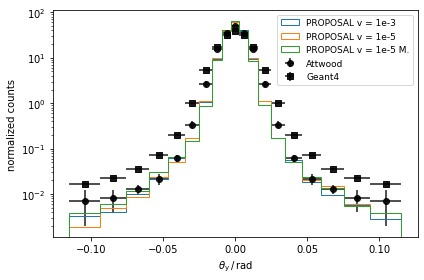

In [12]:
plt.errorbar(ATTWOOD.bin_mids, ATTWOOD.data, fmt='o', color='black', alpha=0.9, yerr=ATTWOOD.data_unc, xerr=ATTWOOD.upper_bin_edge - ATTWOOD.bin_mids, label='Attwood')
plt.errorbar(ATTWOOD.bin_mids, ATTWOOD.G4, fmt='s', color='black', alpha=0.9, yerr=ATTWOOD.G4_unc, xerr=ATTWOOD.upper_bin_edge - ATTWOOD.bin_mids, label='Geant4')


plt.hist(df_0.tracks_109_y, bins=hist_binning, histtype='step', density=True, label='PROPOSAL v = 1e-3')
plt.hist(df_5.tracks_109_y, bins=hist_binning, histtype='step', density=True, label='PROPOSAL v = 1e-5')
plt.hist(df_7.tracks_109_y, bins=hist_binning, histtype='step', density=True, label='PROPOSAL v = 1e-5 M.')

plt.yscale('log')
plt.xlabel(r'$\theta_{\mathrm{y}}\,/\,$rad')
plt.ylabel('normalized counts')
plt.legend(loc='upper right', fontsize=9)
plt.tight_layout()
# plt.savefig(plot_dir + 'attwood_comparison_moliere_E199MeV_final_true.pdf', bbox_inches='tight')

In [13]:
df_01 = pd.read_hdf('data/attwood_199MeV_hydrogen/attwood_run_01.hdf5') # v_cut = 1e-5
df_02 = pd.read_hdf('data/attwood_199MeV_hydrogen/attwood_run_02.hdf5') # v_cut = 1e-5 only Moliere
df_03 = pd.read_hdf('data/attwood_199MeV_hydrogen/attwood_run_03.hdf5') # v_cut = 1e-3


# distance should be 10.9 cm
print(np.unique(df_01.distances))
print(np.unique(df_02.distances))
print(np.unique(df_03.distances))


df_01 = df_01[df_01.distances == 0.109]
df_02 = df_02[df_02.distances == 0.109]
df_03 = df_03[df_03.distances == 0.109]

[0.00022575 0.00027958 0.00040491 ... 0.10844248 0.10861772 0.109     ]
[0.00023931 0.00036267 0.00045276 ... 0.10873776 0.10880655 0.109     ]
[4.13154889e-05 1.53319662e-04 1.97968296e-04 ... 1.09000000e-01
 1.09000000e-01 1.09000000e-01]


In [18]:
len(df_01) / 1e5

99.98908

In [14]:
df_dict_01 = {}
for seed in np.unique(df_01.rnd_seed):
    key = "df_{}".format(int(seed))
    df_dict_01[key] = df_01[df_01.rnd_seed == seed]
    
df_dict_02 = {}
for seed in np.unique(df_02.rnd_seed):
    key = "df_{}".format(int(seed))
    df_dict_02[key] = df_02[df_02.rnd_seed == seed]
    
df_dict_03 = {}
for seed in np.unique(df_03.rnd_seed):
    key = "df_{}".format(int(seed))
    df_dict_03[key] = df_03[df_03.rnd_seed == seed]

In [15]:
hist_data_n_01 = []
# bins = np.append(ATTWOOD.angle_low.values/1000, ATTWOOD.angle_high.values[-1]/1000)
bins = hist_binning
for df in df_dict_01:
    n, x = np.histogram(df_dict_01[df].y_dir_f, bins=bins, density=True)
    hist_data_n_01.append(n)
    hist_data_n_mean_01 = np.mean(hist_data_n_01, axis=0)
hist_data_n_std_01 = np.std(hist_data_n_01, axis=0)
hist_data_n_median_01 = np.median(hist_data_n_01, axis=0)

hist_data_n_02 = []
for df in df_dict_02:
    n, x = np.histogram(df_dict_02[df].y_dir_f, bins=bins, density=True)
    hist_data_n_02.append(n)
    hist_data_n_mean_02 = np.mean(hist_data_n_02, axis=0)
hist_data_n_std_02 = np.std(hist_data_n_02, axis=0)
hist_data_n_median_02 = np.median(hist_data_n_02, axis=0)

hist_data_n_03 = []
for df in df_dict_03:
    n, x = np.histogram(df_dict_03[df].y_dir_f, bins=bins, density=True)
    hist_data_n_03.append(n)
    hist_data_n_mean_03 = np.mean(hist_data_n_03, axis=0)
hist_data_n_std_03 = np.std(hist_data_n_03, axis=0)
hist_data_n_median_03 = np.median(hist_data_n_03, axis=0)

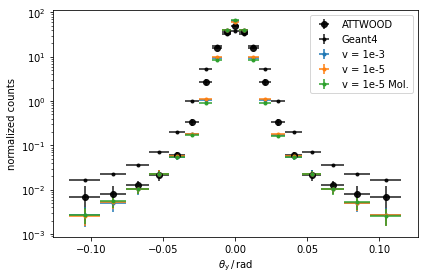

In [16]:
# attwood data
plt.errorbar(ATTWOOD.bin_mids, ATTWOOD.data, fmt='o', color='black', alpha=0.9, yerr=ATTWOOD.data_unc, xerr=ATTWOOD.upper_bin_edge - ATTWOOD.bin_mids, label='ATTWOOD')
plt.errorbar(ATTWOOD.bin_mids, ATTWOOD.G4, fmt='.', color='black', alpha=0.9, yerr=ATTWOOD.G4_unc, xerr=ATTWOOD.upper_bin_edge - ATTWOOD.bin_mids, label='Geant4')

# run 03
plt.errorbar(ATTWOOD.bin_mids, hist_data_n_mean_03, fmt='.', yerr=hist_data_n_std_03, xerr=ATTWOOD.upper_bin_edge - ATTWOOD.bin_mids, label='v = 1e-3')
# plt.errorbar(ATTWOOD.bin_mids, hist_data_n_median_03, fmt='.', 
#              yerr=[hist_data_n_median_03-np.quantile(hist_data_n_03, 0.159, axis=0), np.quantile(hist_data_n_03, 0.841, axis=0)-hist_data_n_median_03],
#              xerr=ATTWOOD.upper_bin_edge - ATTWOOD.bin_mids,
#             label='median+68%')

# run 01
plt.errorbar(ATTWOOD.bin_mids, hist_data_n_mean_01, fmt='.', yerr=hist_data_n_std_01, xerr=ATTWOOD.upper_bin_edge - ATTWOOD.bin_mids, label='v = 1e-5')
# plt.errorbar(ATTWOOD.bin_mids, hist_data_n_median_01, fmt='.', 
#              yerr=[hist_data_n_median_01-np.quantile(hist_data_n_01, 0.159, axis=0), np.quantile(hist_data_n_01, 0.841, axis=0)-hist_data_n_median_01],
#              xerr=ATTWOOD.upper_bin_edge - ATTWOOD.bin_mids,
#             label='median+68%')

# run 02
plt.errorbar(ATTWOOD.bin_mids, hist_data_n_mean_02, fmt='.', yerr=hist_data_n_std_02, xerr=ATTWOOD.upper_bin_edge - ATTWOOD.bin_mids, label='v = 1e-5 Mol.')
# plt.errorbar(ATTWOOD.bin_mids, hist_data_n_median_02, fmt='.', 
#              yerr=[hist_data_n_median_02-np.quantile(hist_data_n_02, 0.159, axis=0), np.quantile(hist_data_n_02, 0.841, axis=0)-hist_data_n_median_02],
#              xerr=ATTWOOD.upper_bin_edge - ATTWOOD.bin_mids,
#             label='median+68%')

plt.yscale('log')
plt.xlabel(r'$\theta_{\mathrm{y}}\,/\,$rad')
plt.ylabel('normalized counts')
plt.legend()
plt.tight_layout()
# plt.savefig(plot_dir + 'attwood_comparison_moliere_199MeV_final_multi_mean.pdf', bbox_inches='tight')